In [50]:
import json, os, itertools
from collections import defaultdict
import gurobipy as gp
import pandas as pd
import numpy as np
import re

BASE_DIR = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json"   
edge_fp   = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json\5 min\edges.json"
route_fp  = os.path.join(BASE_DIR, "routes_nodes.json")
demand_fp = os.path.join(BASE_DIR, "demand.json")
dept_fp   = os.path.join(BASE_DIR, "dep_time.json")

In [51]:
T = 96
max_wait = 5
CAPACITY = 3
failed_edges = {"e81"} # set(), {"e81"}
w1, w2, w3, w4 = 1000, 1000, 100, 500
BIG_M = 10**6
M = T
SINK  = "SINK"
HEADWAY_MIN = 3      
DWELL_MIN = 1     
#DWELL_MAX = max_wait


with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

with open(route_fp, encoding="utf-8") as f:
    routes_nodes = json.load(f)

with open(dept_fp, encoding="utf-8") as f:
    dep_time = {tr: int(t) for tr, t in json.load(f).items()}

with open(demand_fp, encoding="utf-8") as f:
    dem_raw = json.load(f)
demand = {tr: [(o, d, float(q)) for o, d, q in lst] for tr, lst in dem_raw.items()}

trains = list(routes_nodes)
nodes  = {n for _, (s, d, _) in edges.items() for n in (s, d)}
nodes.add(SINK)


# time expansion arcs
arc_list = []              
for eid, (src, dst, tau) in edges.items():
    if eid in failed_edges: continue
    for t in range(T + 1 - tau):
        arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau, t, t+tau))

for n in nodes - {SINK}:
    for w in range(1, max_wait+1):
        for t in range(T + 1 - w):
            arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w, t, t+w))

for n in nodes - {SINK}:
    for t in range(T+1):
        arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0, t, t))

arc_idx = {info: i for i, info in enumerate(arc_list)}


# 캐싱: arc → 노드·시각 별 in/out
out_arcs = defaultdict(list)  
in_arcs  = defaultdict(list)   
node_in_arcs  = defaultdict(list) 
node_out_arcs = defaultdict(list)

for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    n_fr, tt_fr = fr.split("^"); tt_fr = int(tt_fr)
    n_to, tt_to = to.split("^"); tt_to = int(tt_to)

    out_arcs[(n_fr, tt_fr)].append(k)
    in_arcs [(n_to, tt_to)].append(k)

    if not eid.startswith(("w_", "dummy")):     
        node_out_arcs[n_fr].append(k)
        node_in_arcs [n_to].append(k)


# scheduled arrival time
sched = {}
for tr, path in routes_nodes.items():
    t, arr = 0, {path[0]: dep_time[tr]}
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        t += edges[eid][2]; arr[v] = dep_time[tr] + t
    sched[tr] = arr
print("Scheduled arrival times:", sched)

q_r = {tr: sum(q for *_, q in demand[tr]) for tr in trains}
print("Total demand:", sum(q_r.values()))

Scheduled arrival times: {'경부고속철도1_1': {'n4': 0, 'n3': 1, 'n1': 2, 'n2': 4, 'n13': 10, 'n18': 13, 'n28': 16, 'n42': 22, 'n60': 27, 'n72': 31, 'n75': 34, 'n79': 39}, '경부고속철도1_2': {'n4': 3, 'n3': 4, 'n1': 5, 'n2': 7, 'n13': 13, 'n18': 16, 'n28': 19, 'n42': 25, 'n60': 30, 'n72': 34, 'n75': 37, 'n79': 42}, '경부고속철도1_3': {'n4': 6, 'n3': 7, 'n1': 8, 'n2': 10, 'n13': 16, 'n18': 19, 'n28': 22, 'n42': 28, 'n60': 33, 'n72': 37, 'n75': 40, 'n79': 45}, '경부고속철도1_4': {'n4': 9, 'n3': 10, 'n1': 11, 'n2': 13, 'n13': 19, 'n18': 22, 'n28': 25, 'n42': 31, 'n60': 36, 'n72': 40, 'n75': 43, 'n79': 48}, '경부고속철도1_5': {'n4': 12, 'n3': 13, 'n1': 14, 'n2': 16, 'n13': 22, 'n18': 25, 'n28': 28, 'n42': 34, 'n60': 39, 'n72': 43, 'n75': 46, 'n79': 51}, '경부고속철도1_6': {'n4': 15, 'n3': 16, 'n1': 17, 'n2': 19, 'n13': 25, 'n18': 28, 'n28': 31, 'n42': 37, 'n60': 42, 'n72': 46, 'n75': 49, 'n79': 54}, '경부고속철도1_7': {'n4': 18, 'n3': 19, 'n1': 20, 'n2': 22, 'n13': 28, 'n18': 31, 'n28': 34, 'n42': 40, 'n60': 45, 'n72': 49, 'n75': 5

In [52]:
# 노선별로 열차 묶기
def route_prefix(tr_id: str) -> str:
    m = re.match(r'^([^\d]+)\d+_\d+$', tr_id)
    return m.group(1) if m else tr_id.rsplit('_', 1)[0]

by_route = defaultdict(list)
for tr in trains:
    by_route[route_prefix(tr)].append(tr)
print("Trains by route:", dict(by_route))


# 순수주행시간
route_runtime = {}  
for rname, tr_list in by_route.items():
    reps = [tr for tr in tr_list if re.fullmatch(re.escape(rname) + r'\d+_1', tr)]
    if not reps:
        reps = [tr for tr in tr_list if tr.endswith('_1')]
    if not reps:
        reps = [sorted(tr_list)[0]]

    rep = reps[0]
    dest = routes_nodes[rep][-1]
    run = sched[rep][dest] - dep_time[rep]
    route_runtime[rname] = run
print("Route runtimes:", route_runtime)

# T_r = dep_time[r] + route_runtime[prefix(r)] + 4
PADDING_BASE = 4
T_limit = {}
for tr in trains:
    L = len(routes_nodes[tr]) - 1    
    dwell_need = max(0, L-1) * DWELL_MIN    
    base_run = route_runtime[route_prefix(tr)]
    T_limit[tr] = min(T, dep_time[tr] + base_run + dwell_need + PADDING_BASE)
print("Train limits:", T_limit)

Trains by route: {'경부고속철도': ['경부고속철도1_1', '경부고속철도1_2', '경부고속철도1_3', '경부고속철도1_4', '경부고속철도1_5', '경부고속철도1_6', '경부고속철도1_7', '경부고속철도1_8', '경부고속철도1_9', '경부고속철도1_10', '경부고속철도1_11', '경부고속철도1_12', '경부고속철도2_1', '경부고속철도2_2', '경부고속철도2_3', '경부고속철도2_4', '경부고속철도2_5', '경부고속철도2_6', '경부고속철도2_7', '경부고속철도2_8', '경부고속철도2_9', '경부고속철도2_10', '경부고속철도2_11'], '경부선': ['경부선1_1', '경부선1_2', '경부선1_3', '경부선1_4', '경부선1_5', '경부선1_6', '경부선2_1', '경부선2_2', '경부선2_3', '경부선2_4', '경부선2_5', '경부선2_6'], '경북선': ['경북선1_1', '경북선2_1'], '경전선': ['경전선1_1', '경전선1_2', '경전선2_1', '경전선2_2'], '동해선': ['동해선1_1', '동해선1_2', '동해선2_1', '동해선2_2'], '영동선': ['영동선1_1', '영동선2_1'], '장항선': ['장항선1_1', '장항선1_2', '장항선1_3', '장항선2_1', '장항선2_2', '장항선2_3'], '전라선': ['전라선1_1', '전라선1_2', '전라선1_3', '전라선2_1', '전라선2_2', '전라선2_3'], '중앙선': ['중앙선1_1', '중앙선1_2', '중앙선1_3', '중앙선1_4', '중앙선1_5', '중앙선1_6', '중앙선2_1', '중앙선2_2', '중앙선2_3', '중앙선2_4', '중앙선2_5', '중앙선2_6'], '충북선': ['충북선1_1', '충북선1_2', '충북선1_3', '충북선2_1', '충북선2_2', '충북선2_3'], '호남고속철도': ['호남고속철도1_1', '호남고속철도1_2', '호남고속철도1

In [53]:
# 계획 엣지 / blocked / 접미 실패 / 종료 허용노드
uv2eid = {}
dup_keys = set()
for eid, (s, d, _) in edges.items():
    key = (s, d)
    if key in uv2eid and uv2eid[key] != eid:
        dup_keys.add(key)
    else:
        uv2eid[key] = eid

if dup_keys:
    print(f"[warn] multiple eids share the same (u,v): {sorted(list(dup_keys))[:5]} ...")

def planned_eids_of(tr):
    """열차 tr의 계획 경로 상 (u,v)들에 대한 eid 리스트를 O(1)로 반환"""
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid.get((u, v))
        if eid is None:
            raise KeyError(f"No edge (u={u} -> v={v}) found in edges; check routes_nodes or edges.json")
        eids.append(eid)
    return eids

# 이제 O(1)로 추출
planned_eids = {tr: planned_eids_of(tr) for tr in trains}
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr])) for tr in trains}

# 이 열차의 계획경로가 실패엣지를 포함하면 blocked=1
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr]))
           for tr in trains}

# 접미 실패 플래그 F_{r,i}와 reach_r, 그리고 노드별 종료 허용 allow_stop[(tr,n)]
allow_stop = {}
reach = {}
for tr in trains:
    path = routes_nodes[tr]      
    eids = planned_eids[tr]      
    L = len(path) - 1

    t_sched_term = sched[tr].get(path[-1], 10**9)
    reach[tr] = int(t_sched_term <= T_limit[tr]) 

    suffix_failed = [0]*(L+1)
    hit = 0
    for i in range(L-1, -1, -1):
        if eids[i] in failed_edges:
            hit = 1
        suffix_failed[i] = hit

    for i in range(1, L+1):
        n = path[i]
        if i == L:
            allow = 1
        elif reach[tr] == 0:
            allow = 1
        else:
            allow = suffix_failed[i]
        allow_stop[(tr, n)] = int(allow)

eid_to_arcidx = defaultdict(list)
dummy_idx_of = defaultdict(list)
for k, (_, _, eid, *_ ) in enumerate(arc_list):
    if str(eid).startswith("dummy_"):
        n = eid.split("dummy_")[1]
        dummy_idx_of[n].append(k)
    elif not str(eid).startswith("w_"):
        eid_to_arcidx[eid].append(k)
     
T_aff = [tr for tr in trains if blocked[tr] == 1]  
T_ok  = [tr for tr in trains if blocked[tr] == 0]  

In [54]:
def build_base_model():

    m = gp.Model(); m.Params.OutputFlag = 1
    nA, nT = len(arc_list), len(trains)

    # 공통 변수 (모든 열차)
    x = m.addVars(nA, nT, vtype=gp.GRB.BINARY, name="x")
    t_arr = {(tr, n): m.addVar(lb=0, ub=T, vtype=gp.GRB.INTEGER, name=f"tarr[{tr},{n}]")
             for tr in trains for n in nodes - {SINK}}
    delta = {(tr,o,d): m.addVar(lb=0, name=f"delta[{tr},{o},{d}]")
             for tr in trains for (o,d,_) in demand[tr]}

    # T_aff만 추가 변수  ### CHG
    h = {}
    y = {}
    s = {}
    z = {}
    u_eid = {}

    if T_aff:
        h = m.addVars(T_aff, vtype=gp.GRB.BINARY, name="h")
        y = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"y[{tr},{n}]")
             for tr in T_aff for n in routes_nodes[tr][1:]}
        s = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"s[{tr},{n}]")
             for tr in T_aff for n in nodes - {SINK}}
        z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY, name=f"z[{tr},{o},{d}]")
             for tr in T_aff for (o,d,_) in demand[tr]}

        # 우회 허용: 계획에 없는 eid만 u_eid 생성 + x ≤ u_eid  
        real_eids = {eid for (_,_,eid,_,_,_) in arc_list if not str(eid).startswith(("w_","dummy"))}
        for tr in T_aff:
            P = set(planned_eids[tr])
            for eid in real_eids:
                if eid in P:
                    continue
                u_eid[(tr, eid)] = m.addVar(vtype=gp.GRB.BINARY, name=f"u_eid[{tr},{eid}]")
                for k in eid_to_arcidx[eid]:
                    ti = trains.index(tr)
                    m.addConstr(x[k, ti] <= u_eid[(tr, eid)])

    





    #############################################################################################

    # real eid만 포함된다고 가정(eid_to_arcidx의 키가 real eid)
    node_in_eids  = defaultdict(list)  # i로 들어오는 eid들
    node_out_eids = defaultdict(list)  # i에서 나가는 eid들
    for eid in eid_to_arcidx.keys():
        u, v, tau = edges[eid]   # (src, dst, tau)
        node_out_eids[u].append(eid)
        node_in_eids[v].append(eid)

    e_time = {(tr, eid): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"e[{tr},{eid}]")
          for tr in trains for eid in eid_to_arcidx}
    d_time = {(tr, eid): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"d[{tr},{eid}]")
            for tr in trains for eid in eid_to_arcidx}
        
    # L0' : 한 열차가 같은 물리 eid를 두 번 쓰지 않도록 (안전)
    for tr in trains:
        ti = trains.index(tr)
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(gp.quicksum(x[k, ti] for k in idxs) <= 1, name=f"L0[{tr},{eid}]")

    # e,d = x 가중합
    for tr in trains:
        ti = trains.index(tr)
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(
                e_time[(tr, eid)] == gp.quicksum(arc_list[k][4] * x[k, ti] for k in idxs),
                name=f"e_link[{tr},{eid}]"
            )
            m.addConstr(
                d_time[(tr, eid)] == gp.quicksum(arc_list[k][5] * x[k, ti] for k in idxs),
                name=f"d_link[{tr},{eid}]"
            )

    # Dwelling constraint
    for tr in trains:
        ti = trains.index(tr)
        for i in (nodes - {routes_nodes[tr][0], SINK}):     # 노드 i를 순회하되 해당 열차의 출발, 종착은 제외 (중간 정차역에 대해서만 dwell 제약을 둘거임)
            for e_in in node_in_eids[i]:    # 노드 i로 유입되는 실제 선로 eid 순회
                alpha_in = x.sum(eid_to_arcidx[e_in], ti)   # 열차가 e_in에 해당하는 시간확장 아크들 중 하나라도 선택했는지의 합 (0 or 1)
                for e_out in node_out_eids[i]:  # 노드 i에서 유출되는 실제 선로 eid 순회
                    alpha_out = x.sum(eid_to_arcidx[e_out], ti)   # 열차가 e_out에 해당하는 시간확장 아크들 중 하나라도 선택했는지의 합 (0 or 1)
                    m.addConstr(
                        e_time[(tr, e_out)] - d_time[(tr, e_in)]
                        + M * (2 - alpha_in - alpha_out)  # alpha_in, alpha_out이 둘 다 1일 때(= 실제로 i에서 e_in으로 들어와 e_out으로 나가는 경우
                        >= DWELL_MIN,
                        name=f"dwell_pair[{tr},{i},{e_in}->{e_out}]"
                    ) 


    # Headway constraint
    M_HW = T 

    trains_using_eid = defaultdict(list)
    for tr in trains:
        for e in planned_eids[tr]:
            if e in eid_to_arcidx:  
                trains_using_eid[e].append(tr)

    def alpha(tr, e):
        """열차 tr이 물리 eid=e의 시간아크 중 하나를 썼는지(0/1 합)"""
        return x.sum(eid_to_arcidx[e], trains.index(tr))

    for e in eid_to_arcidx.keys():
        ok_list  = [tr for tr in trains_using_eid.get(e, []) if tr in T_ok]
        aff_list = list(set([tr for tr in trains_using_eid.get(e, []) if tr in T_aff]) | set(T_aff))

        # ---------- (A) 동일 유형: OK–OK ----------
        for tr1, tr2 in itertools.combinations(ok_list, 2):
            a1, a2 = alpha(tr1, e), alpha(tr2, e)
            if dep_time[tr1] <= dep_time[tr2]:
                m.addConstr(
                    e_time[(tr2, e)] - e_time[(tr1, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_ein_ok_fifo[{e},{tr1},{tr2}]"
                )
                m.addConstr(
                    d_time[(tr2, e)] - d_time[(tr1, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_eout_ok_fifo[{e},{tr1},{tr2}]"
                )
            else:
                m.addConstr(
                    e_time[(tr1, e)] - e_time[(tr2, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_ein_ok_fifo[{e},{tr2},{tr1}]"
                )
                m.addConstr(
                    d_time[(tr1, e)] - d_time[(tr2, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_eout_ok_fifo[{e},{tr2},{tr1}]"
                )

        # ---------- (B) 동일 유형: AFF–AFF ----------
        for tr1, tr2 in itertools.combinations(aff_list, 2):
            a1, a2 = alpha(tr1, e), alpha(tr2, e)
            if dep_time[tr1] <= dep_time[tr2]:
                m.addConstr(
                    e_time[(tr2, e)] - e_time[(tr1, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_ein_aff_fifo[{e},{tr1},{tr2}]"
                )
                m.addConstr(
                    d_time[(tr2, e)] - d_time[(tr1, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_eout_aff_fifo[{e},{tr1},{tr2}]"
                )
            else:
                m.addConstr(
                    e_time[(tr1, e)] - e_time[(tr2, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_ein_aff_fifo[{e},{tr2},{tr1}]"
                )
                m.addConstr(
                    d_time[(tr1, e)] - d_time[(tr2, e)] + M_HW*(2 - a1 - a2) >= HEADWAY_MIN,
                    name=f"hw_eout_aff_fifo[{e},{tr2},{tr1}]"
                )

        # ---------- (C) 상이한 유형: OK – AFF (OK 우선) ----------
        for tr_ok in ok_list:
            for tr_aff in aff_list:
                a_ok, a_aff = alpha(tr_ok, e), alpha(tr_aff, e)
                m.addConstr(
                    e_time[(tr_aff, e)] - e_time[(tr_ok, e)] + M_HW*(2 - a_ok - a_aff) >= HEADWAY_MIN,
                    name=f"hw_ein_ok_aff[{e},{tr_ok},{tr_aff}]"
                )
                m.addConstr(
                    d_time[(tr_aff, e)] - d_time[(tr_ok, e)] + M_HW*(2 - a_ok - a_aff) >= HEADWAY_MIN,
                    name=f"hw_eout_ok_aff[{e},{tr_ok},{tr_aff}]"
                )
    # ================================================================================ 

    ######################################################################################################









    # T_ok: 비계획 eid는 x=0으로 막아 경로공간 축소
    for tr in T_ok:
        ti = trains.index(tr)
        P = set(planned_eids[tr])
        for eid in eid_to_arcidx.keys():
            if eid not in P:
                for k in eid_to_arcidx[eid]:
                    x[k, ti].UB = 0  # 비계획 아크 사용 금지

    # --- 출발/흐름 보존 ---
    for tr in T_aff:
        tr_i = trains.index(tr)
        r_o, t_dep = routes_nodes[tr][0], dep_time[tr]
        m.addConstr(x.sum(out_arcs[(r_o, t_dep)], tr_i) == h[tr])
        # 노드-시간 보존
        for n in nodes - {SINK}:
            for t in range(T+1):
                inflow  = x.sum(in_arcs[(n, t)],  tr_i)
                outflow = x.sum(out_arcs[(n, t)], tr_i)
                if (n == r_o) and (t == t_dep):
                    m.addConstr(outflow - inflow == h[tr])
                else:
                    m.addConstr(inflow == outflow)

    for tr in T_ok:
        tr_i = trains.index(tr)
        r_o, t_dep = routes_nodes[tr][0], dep_time[tr]
        # 취소 불가 → 반드시 출발 1
        m.addConstr(x.sum(out_arcs[(r_o, t_dep)], tr_i) == 1)
        for n in nodes - {SINK}:
            for t in range(T+1):
                inflow  = x.sum(in_arcs[(n, t)],  tr_i)
                outflow = x.sum(out_arcs[(n, t)], tr_i)
                if (n == r_o) and (t == t_dep):
                    m.addConstr(outflow - inflow == 1)
                else:
                    m.addConstr(inflow == outflow)

    # --- 종료 허용노드 처리 (더미 아크) ---
    # 허용되지 않는 노드의 더미 아크는 모두 금지
    for tr in trains:
        for n in routes_nodes[tr][1:]:
            if allow_stop[(tr, n)] == 0:
                for k in dummy_idx_of[n]:
                    ti = trains.index(tr)
                    x[k, ti].UB = 0
    # T_aff: y로 종료 선택
    for tr in T_aff:
        tr_i = trains.index(tr)
        cand = routes_nodes[tr][1:]
        m.addConstr(gp.quicksum(y[tr, n] for n in cand) == h[tr])
        for n in cand:
            idx_dum = dummy_idx_of[n]
            m.addConstr(x.sum(idx_dum, tr_i) == y[tr, n])
        # 허용 안 되는 노드는 위에서 x UB=0, 여기선 y=0
        for n in cand:
            if allow_stop[(tr, n)] == 0:
                y[tr, n].UB = 0
    # T_ok: y 없이 “더미 1개” 직접 강제
    for tr in T_ok:
        tr_i = trains.index(tr)
        cand = [n for n in routes_nodes[tr][1:] if allow_stop[(tr, n)] == 1]
        lhs = 0
        for n in cand:
            lhs += x.sum(dummy_idx_of[n], tr_i)
        m.addConstr(lhs == 1)

    # --- s(방문) & z 로직: T_aff만 ---
    for tr in T_aff:
        tr_i = trains.index(tr)
        for n in nodes - {SINK}:
            idx = node_out_arcs[n] + node_in_arcs[n]
            flow = x.sum(idx, tr_i)
            m.addConstr(flow >= s[tr, n])
            m.addConstr(flow <= BIG_M * s[tr, n])
        for (o, d, q) in demand[tr]:
            m.addConstr(z[tr, o, d] <= s[tr, o])
            m.addConstr(z[tr, o, d] <= s[tr, d])
            m.addConstr(z[tr, o, d] >= s[tr, o] + s[tr, d] - 1)
            m.addConstr(z[tr, o, d] <= h[tr])


    # --- t_arr 링킹 (모든 열차) ---
    for tr in trains: 
        tr_i = trains.index(tr) 
        for k, (fr, to, eid, *_ ) in enumerate(arc_list): 
            if str(eid).startswith(("w_", "dummy")): 
                continue 
            n_to, tt = to.split("^"); tt = int(tt) 
            m.addConstr(t_arr[tr, n_to] >= tt - BIG_M * (1 - x[k, tr_i])) 
            m.addConstr(t_arr[tr, n_to] <= tt + BIG_M * (1 - x[k, tr_i])) 

            # --- (추가) 기차별 시간상한: r ∈ R_aff (y로 종착노드 선택) 
            for tr in T_aff: 
                Tlim = T_limit[tr] 
                for n in routes_nodes[tr][1:]: # 종착 후보들 
                    # y[tr,n] = 1로 그 노드에서 종료하면 t_arr[tr,n] ≤ Tlim 이 강제됨 
                    m.addConstr( t_arr[tr, n] <= Tlim + BIG_M * (1 - y[tr, n]), name=f"timecap_aff[{tr},{n}]" ) 
            
            # --- (추가) 기차별 시간상한: r ∈ R_ok (y 없이 dummy-arc 합으로 종착노드 지표 대체) 
            for tr in T_ok: 
                Tlim = T_limit[tr] 
                tr_i = trains.index(tr) 
                for n in [nn for nn in routes_nodes[tr][1:] 
                if allow_stop[(tr, nn)] == 1]: # 이 합은 해당 노드 n에서의 종료 dummy arc 사용(시간 미포함 합계)이 1이면 활성화 
                    term_n = x.sum(dummy_idx_of[n], tr_i) m.addConstr( t_arr[tr, n] <= Tlim + BIG_M * (1 - term_n), name=f"timecap_ok[{tr},{n}]" )


    # --- δ 제약 ---
    # T_aff: 기존처럼 z로 게이트
    for tr in T_aff:
        for (o, d, q) in demand[tr]:
            sched_t = sched[tr].get(d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t - BIG_M * (1 - z[tr, o, d]))
            m.addConstr(delta[tr, o, d] <= BIG_M * z[tr, o, d])
    # T_ok: z 없이 “지연만” 측정
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            sched_t = sched[tr].get(d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t)
            # delta는 lb=0 이므로 자연히 max(0, …)


    # --- 목적함수 ---
    obj = 0
    # T_aff: 취소/미서빙/지연 + 우회
    for tr in T_aff:
        obj += w1 * q_r[tr] * (1 - h[tr])
        for (o, d, q) in demand[tr]:
            obj += w2 * q * (1 - z[tr, o, d])
            obj += w3 * q * delta[tr, o, d]
    if u_eid:
        obj += w4 * gp.quicksum(u_eid.values())

    # T_ok: 지연만 패널티
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            obj += w3 * q * delta[tr, o, d]

    m.setObjective(obj, sense=gp.GRB.MINIMIZE)
    return m, x, t_arr, delta, h, z

# cap_map: (eid,tt) → [arcIdx …]
cap_map = defaultdict(list)
for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    if str(eid).startswith(("w_", "dummy")): 
        continue
    for tt in range(t0, t1):
        cap_map[(eid, tt)].append(k)

SyntaxError: invalid syntax (3342871547.py, line 287)

In [ ]:
# ===== Active-set (working set) 용량 반복 동일 유지 =====
working_set, sol_prev = set(), None
MAX_ITER, EPS, SHOW = 40, 1e-6, 30

for it in range(MAX_ITER):
    base, xvar, t_arr_var, delta_var, hvar, zvar = build_base_model()
    constr_refs = {}
    for (eid, tt) in working_set:
        expr = gp.quicksum(xvar[idx, ti] for idx in cap_map[(eid, tt)]
                           for ti in range(len(trains)))
        constr_refs[(eid, tt)] = base.addConstr(expr <= CAPACITY,
                                               name=f"cap_{eid}_{tt}")

    if sol_prev:
        for (idx, ti), v in sol_prev.items():
            xvar[idx, ti].Start = v

    base.optimize()

    if base.Status == gp.GRB.INFEASIBLE:
        base.computeIIS()
        base.write(f"iis_iter{it}.ilp")   # 반복 번호 붙여 저장
        raise RuntimeError("infeasible (IIS written)")
    elif base.Status != gp.GRB.OPTIMAL:
        raise RuntimeError(f"non-optimal status: {base.Status}")


    x_val = {(idx, ti): round(xvar[idx, ti].X)
         for idx in range(len(arc_list))
         for ti  in range(len(trains))}
    
    # ③-c violation search
    x_mat = np.zeros((len(arc_list), len(trains)), dtype=np.uint8)
    for (idx, ti), v in x_val.items():      # x_val 은 아래에서 다시 만듦
        if v: x_mat[idx, ti] = 1
    cap_keys   = list(cap_map)                       
    cap_idxarr = [np.fromiter(cap_map[k], dtype=int)  
                for k in cap_keys]
    viol = set()
    for k, idx_arr in zip(cap_keys, cap_idxarr):
        if x_mat[idx_arr].sum() > CAPACITY + EPS:
            viol.add(k)

    # ③-d negative dual search
    neg_pi = set()
    lp = base.relax(); lp.optimize()
    if lp.Status == gp.GRB.OPTIMAL:
        for key, c in constr_refs.items():
            if c.Pi < -EPS: neg_pi.add(key)
            
    # ③-e working-set update
    updated = False
    for k in viol:
        if k not in working_set: working_set.add(k); updated = True
    for k in neg_pi:
        if k in working_set: working_set.remove(k); updated = True

    ws = sorted(working_set)
    print(f"[Iter {it}] |W|={len(ws)}  preview={ws[:SHOW]}")
    print(f"          add={len(viol)} drop={len(neg_pi)}")
    sol_prev = x_val
    if not updated:
        print("↳ converged"); break
else:
    print("⚠ MAX_ITER reached")

Set parameter OutputFlag to value 1


MemoryError: 

In [ ]:
pd.set_option('display.max_rows', None)

def h_get(tr):
    if tr in T_aff:
        return float(hvar[tr].X)
    return 1.0

# 1) Timetable
rows = []
for tr_i, tr in enumerate(trains):
    if h_get(tr) < 0.5:
        rows.append([tr, '-', '-', '-', '-', 'Cancelled'])
        continue
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not str(arc_list[k][2]).startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    for dep, frm, to, arr, eid in legs:
        rows.append([tr, frm, dep, to, arr, eid])

df = pd.DataFrame(rows, columns=["Train", "From", "Dep", "To", "Arr", "Edge"])
print("\n=== Timetable (head) ===")
display(df)

# 2) 유틸리티
def planned_path_and_eids(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        eids.append(eid)
    return path, eids

def build_actual_legs(tr):
    tr_i = trains.index(tr)
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not str(arc_list[k][2]).startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    return legs

def path_nodes_from_legs(legs):
    if not legs: return []
    nodes_seq = [legs[0][1]]
    for _, _, to, _, _ in legs:
        nodes_seq.append(to)
    return nodes_seq

def actual_arrival_map(legs):
    amap = {}
    for _, frm, to, arr, _ in legs:
        if to not in amap or arr < amap[to]:
            amap[to] = arr
    return amap

# 3) 상태 요약
stat_rows = []
for tr in trains:
    departed = (h_get(tr) >= 0.5)
    planned_path, planned_eids = planned_path_and_eids(tr)
    planned_terminal = planned_path[-1]
    planned_terminal_sched = sched[tr].get(planned_terminal, None)

    if not departed:
        stat_rows.append({
            "Train": tr, "Departed": False, "ArrivedInHorizon": False,
            "PlannedTerminal": planned_terminal,
            "ActualTerminal": None,
            "Delay(min)": None, "HorizonDelay(min)": None,
            "Truncated": False, "Rerouted": False, "Status": "Cancelled"
        })
        continue

    legs = build_actual_legs(tr)
    actual_nodes = path_nodes_from_legs(legs)
    actual_eids  = [e for *_, e in legs]
    arr_map      = actual_arrival_map(legs)
    actual_terminal = actual_nodes[-1] if actual_nodes else None
    actual_arrival  = max(arr for *_, arr, _ in legs) if legs else None

    prefix_last_idx = 0
    for i, node in enumerate(planned_path):
        t_planned = sched[tr].get(node, None)
        if t_planned is not None and t_planned <= T:
            prefix_last_idx = i
    planned_prefix_nodes = planned_path[:prefix_last_idx+1]
    planned_prefix_eids  = planned_eids[:max(0, prefix_last_idx)]

    arrived_in_horizon = (actual_terminal == planned_terminal) and (actual_arrival is not None) and (actual_arrival <= T)
    if planned_terminal_sched is not None and planned_terminal_sched <= T:
        truncated = (not arrived_in_horizon)
    else:
        truncated = False

    common = min(len(actual_eids), len(planned_prefix_eids))
    rerouted = (actual_eids[:common] != planned_prefix_eids[:common])

    delay_min = None
    horizon_delay_min = None
    if planned_terminal_sched is not None and planned_terminal_sched <= T and arrived_in_horizon:
        delay_min = max(0, actual_arrival - planned_terminal_sched)

    if planned_prefix_nodes:
        last_plan_node = planned_prefix_nodes[-1]
        t_plan_last    = sched[tr].get(last_plan_node, None)
        t_act_last     = arr_map.get(last_plan_node, None)
        if (t_plan_last is not None) and (t_act_last is not None):
            horizon_delay_min = max(0, t_act_last - t_plan_last)

    if not departed:
        status = "Cancelled"
    elif truncated:
        status = "Truncated"
    elif rerouted:
        status = "Rerouted"
    elif (planned_terminal_sched is not None and planned_terminal_sched <= T and delay_min and delay_min > 0) \
         or (horizon_delay_min is not None and horizon_delay_min > 0):
        status = "Delayed"
    else:
        if planned_terminal_sched is not None and planned_terminal_sched > T and not arrived_in_horizon:
            status = "On-time & in-progress"
        else:
            status = "On-time & complete"

    stat_rows.append({
        "Train": tr,
        "Departed": True,
        "ArrivedInHorizon": arrived_in_horizon,
        "PlannedTerminal": planned_terminal,
        "ActualTerminal": actual_terminal,
        "Delay(min)": delay_min,
        "HorizonDelay(min)": horizon_delay_min,
        "Truncated": truncated,
        "Rerouted": rerouted,
        "Status": status
    })

df_stat = pd.DataFrame(stat_rows, columns=[
    "Train","Departed","ArrivedInHorizon","PlannedTerminal","ActualTerminal",
    "Delay(min)","HorizonDelay(min)","Truncated","Rerouted","Status"
])
print("\n=== Train status summary — horizon-aware (T-based) ===")
display(df_stat)



=== Timetable (head) ===


,Train,From,Dep,To,Arr,Edge
0,경부고속철도1_1,n4,0,n3,1,e4
1,경부고속철도1_1,n3,2,n1,3,e3
2,경부고속철도1_1,n1,4,n2,6,e1
3,경부고속철도1_1,n2,7,n13,13,e9r
4,경부고속철도1_1,n13,14,n18,17,e17r
5,경부고속철도1_1,n18,18,n28,21,e26
6,경부고속철도1_1,n28,22,n42,28,e43r
7,경부고속철도1_1,n42,29,n60,34,e61
8,경부고속철도1_2,n4,3,n3,4,e4
9,경부고속철도1_2,n3,5,n1,6,e3



=== Train status summary — horizon-aware (T-based) ===


,Train,Departed,ArrivedInHorizon,PlannedTerminal,ActualTerminal,Delay(min),HorizonDelay(min),Truncated,Rerouted,Status
0,경부고속철도1_1,True,False,n79,n60,NaN,NaN,True,False,Truncated
1,경부고속철도1_2,True,False,n79,n60,NaN,NaN,True,False,Truncated
2,경부고속철도1_3,True,False,n79,n60,NaN,NaN,True,False,Truncated
3,경부고속철도1_4,True,False,n79,n60,NaN,NaN,True,False,Truncated
4,경부고속철도1_5,True,False,n79,n60,NaN,NaN,True,False,Truncated
5,경부고속철도1_6,True,False,n79,n60,NaN,NaN,True,False,Truncated
6,경부고속철도1_7,True,False,n79,n60,NaN,NaN,True,False,Truncated
7,경부고속철도1_8,True,False,n79,n60,NaN,NaN,True,False,Truncated
8,경부고속철도1_9,True,False,n79,n60,NaN,NaN,True,False,Truncated
9,경부고속철도1_10,True,False,n79,n60,NaN,NaN,True,False,Truncated


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_26072\176890637.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_26072\176890637.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))


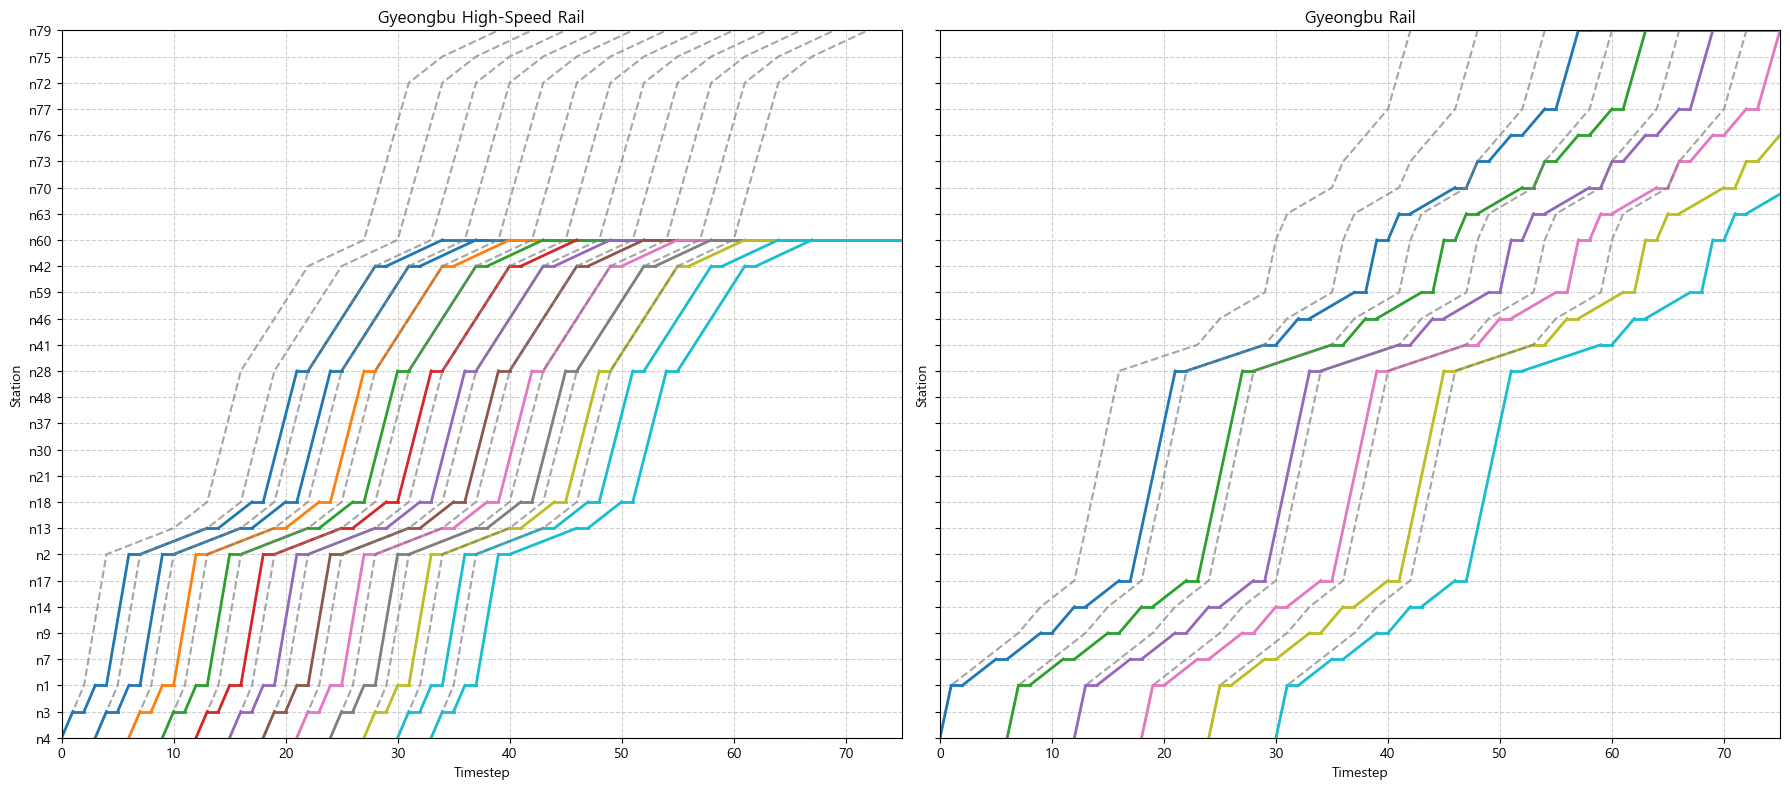

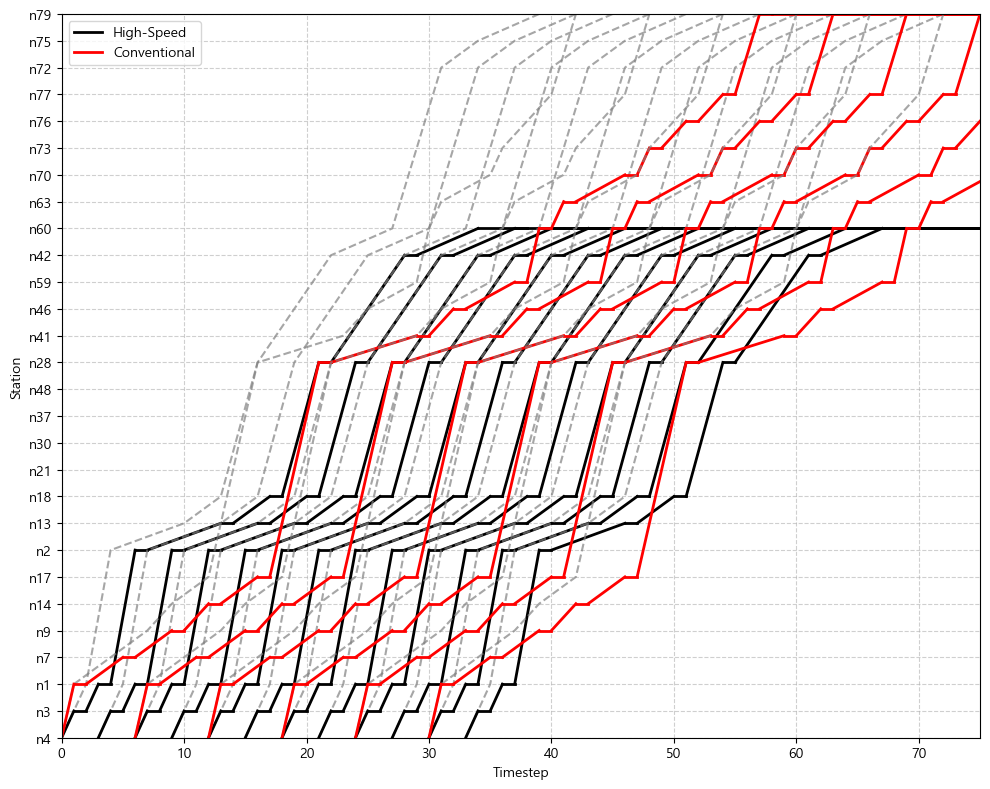

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SINK = "SINK"

# 1) routes_nodes의 순서를 그대로 존중하면서 여러 경로를 하나로 병합
def merge_orders(base_order, new_order):
    """
    base_order 뒤에 new_order의 노드를 '이웃'을 기준으로 자연스럽게 삽입한다.
    - new_order[i-1]이 base에 있으면 그 뒤에 삽입
    - 아니면 new_order[i+1]이 base에 있으면 그 앞에 삽입
    - 둘 다 없으면 맨 뒤에 추가
    """
    res = list(base_order)
    for i, node in enumerate(new_order):
        if node in res:
            continue
        prev_node = new_order[i-1] if i > 0 else None
        next_node = new_order[i+1] if i+1 < len(new_order) else None
        if prev_node in res:
            res.insert(res.index(prev_node) + 1, node)
        elif next_node in res:
            res.insert(res.index(next_node), node)
        else:
            res.append(node)
    return res

def build_canonical_station_order(route_ids, routes_nodes):
    """
    route_ids: routes_nodes에서 가져올 '경부고속철도1_1', '경부선1_1' 등 경로 ID 리스트
    반환: 두(여러) 노선을 '나열된 순서대로' 병합한 단일 역 리스트
    """
    order = []
    for rid in route_ids:
        seq = routes_nodes[rid]
        order = merge_orders(order, seq)
    return order

# 2) 플롯 함수: 외부에서 만든 station_map을 사용하도록 변경
def plot_train_paths(train_list, ax, title, x_val, arc_list, h_get, 
                     routes_nodes, sched, station_map, xmax, color=None, label=None):
    ax.set_title(title)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Station")

    # 공통 y축
    order = list(station_map.keys())
    yticks = [station_map[n] for n in order]
    ax.set_yticks(yticks)
    ax.set_yticklabels(order)

    # 색상 설정
    if color is None:  # fig.1 스타일 → cmap
        cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
        color_iter = (cmap(i % cmap.N) for i in range(len(train_list)))
    else:  # fig.2 스타일 → 단일색
        color_iter = (color for _ in range(len(train_list)))

    for tr, tr_color in zip(train_list, color_iter):
        if h_get(tr) < 0.5:
            continue

        # --- 계획 경로(점선, 회색) ---
        planned_path = routes_nodes[tr]
        p_nodes = [n for n in planned_path if n in station_map]
        if len(p_nodes) >= 2:
            p_times = [sched[tr][n] for n in p_nodes]
            p_ys    = [station_map[n] for n in p_nodes]
            ax.plot(p_times, p_ys, linestyle='--', color='gray', alpha=0.7)

        # --- 실제 경로 ---
        actual_legs = []
        tr_i = trains.index(tr)
        for k in range(len(arc_list)):
            if x_val.get((k, tr_i), 0) > 0.5:
                fr, to, eid, *_ = arc_list[k]
                u, t0 = fr.split("^")
                v, t1 = to.split("^")
                if u == SINK or v == SINK:
                    continue
                actual_legs.append((int(t0), u, v, int(t1), eid))
        actual_legs.sort(key=lambda x: x[0])
        if not actual_legs:
            continue

        # 첫 구간
        t0, u, v, t1, _ = actual_legs[0]
        if u in station_map and v in station_map:
            ax.plot([t0, t1], [station_map[u], station_map[v]], 
                    color=tr_color, linewidth=2, label=label)
            label = None  # 첫 선만 legend에 표시

        # 이후 구간 + 대기
        for i in range(1, len(actual_legs)):
            p_t0, p_u, p_v, p_t1, _ = actual_legs[i-1]
            c_t0, c_u, c_v, c_t1, _ = actual_legs[i]

            if c_t0 > p_t1 and p_v == c_u and p_v in station_map:
                ax.plot([p_t1, c_t0], [station_map[p_v], station_map[c_u]],
                        color='r', linestyle=':', linewidth=1.8)

            if c_u in station_map and c_v in station_map:
                ax.plot([c_t0, c_t1], [station_map[c_u], station_map[c_v]], 
                        color=tr_color, linewidth=2)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, xmax)
    ax.set_ylim(1, len(station_map))

# 3) 병합 기준 역 순서 만들기 (두 노선 합쳐서 하나의 y축)
# ── (A) 열차 묶기: 고속/일반 이름 접두사로 분류 ──
# 예: '경부고속철도...', '경부선...'
gbrt_trains = [tr for tr in trains if str(tr).startswith('경부고속철도1')]
gbs_trains  = [tr for tr in trains if str(tr).startswith('경부선1')]
gbh_trains = [tr for tr in trains if str(tr).startswith('호남고속철도1')]

# 대표 노선 id 선택 (없으면 가장 긴 경로로 대체)
def pick_representative(tr_list):
    return max(tr_list, key=lambda tr: len(routes_nodes[tr])) if tr_list else None

merge_route_ids = []
if '경부고속철도1_1' in routes_nodes:
    merge_route_ids.append('경부고속철도1_1')
elif gbrt_trains:
    merge_route_ids.append(pick_representative(gbrt_trains))

if '경부선1_1' in routes_nodes:
    merge_route_ids.append('경부선1_1')
elif gbs_trains:
    merge_route_ids.append(pick_representative(gbs_trains))

if '호남고속철도1_1' in routes_nodes:
    merge_route_ids.append('호남고속철도1_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))

# 만약 둘 다 비면(데이터셋에서 못 찾으면) 안전하게 아무거나 2개 뽑기
if not merge_route_ids:
    merge_route_ids = [pick_representative(trains)]

# ── (B) h_get 정의: T_aff에만 h가 있을 때를 대비 ──
# hvar가 있으면 값, 없거나 T_ok면 1.0(운행)로 간주
try:
    _ = hvar  # 존재 검사
    def h_get(tr):
        try:
            return float(hvar[tr].X)  # T_aff
        except KeyError:
            return 1.0                # T_ok (취소 불가 모델이면 항상 1)
except NameError:
    h_get = lambda tr: 1.0

# ── (C) 병합 y축(station_map) 만들기 ──
canonical_order = build_canonical_station_order(merge_route_ids, routes_nodes)
# 혹시 병합 결과가 비면(방어)
if not canonical_order:
    # 전체 노드에서 자주 등장 순으로 임의 y축 만들기
    from collections import Counter
    cnt = Counter(n for seq in routes_nodes.values() for n in seq if n != SINK)
    canonical_order = [n for n, _ in cnt.most_common()]

station_map = {name: i+1 for i, name in enumerate(canonical_order)}


# --- fig.1 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

plot_train_paths(gbrt_trains, ax1, "Gyeongbu High-Speed Rail", 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, xmax=75)
plot_train_paths(gbs_trains,  ax2, "Gyeongbu Rail",     
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, xmax=75)

plt.tight_layout()
plt.show()

# --- fig.2 ---
fig2, ax = plt.subplots(figsize=(10, 8))

plot_train_paths(gbrt_trains, ax, None, 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, 
                 xmax=75, color="black", label="High-Speed")

plot_train_paths(gbs_trains, ax, None, 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, 
                 xmax=75, color="red", label="Conventional")

ax.legend()
plt.tight_layout()
plt.show()

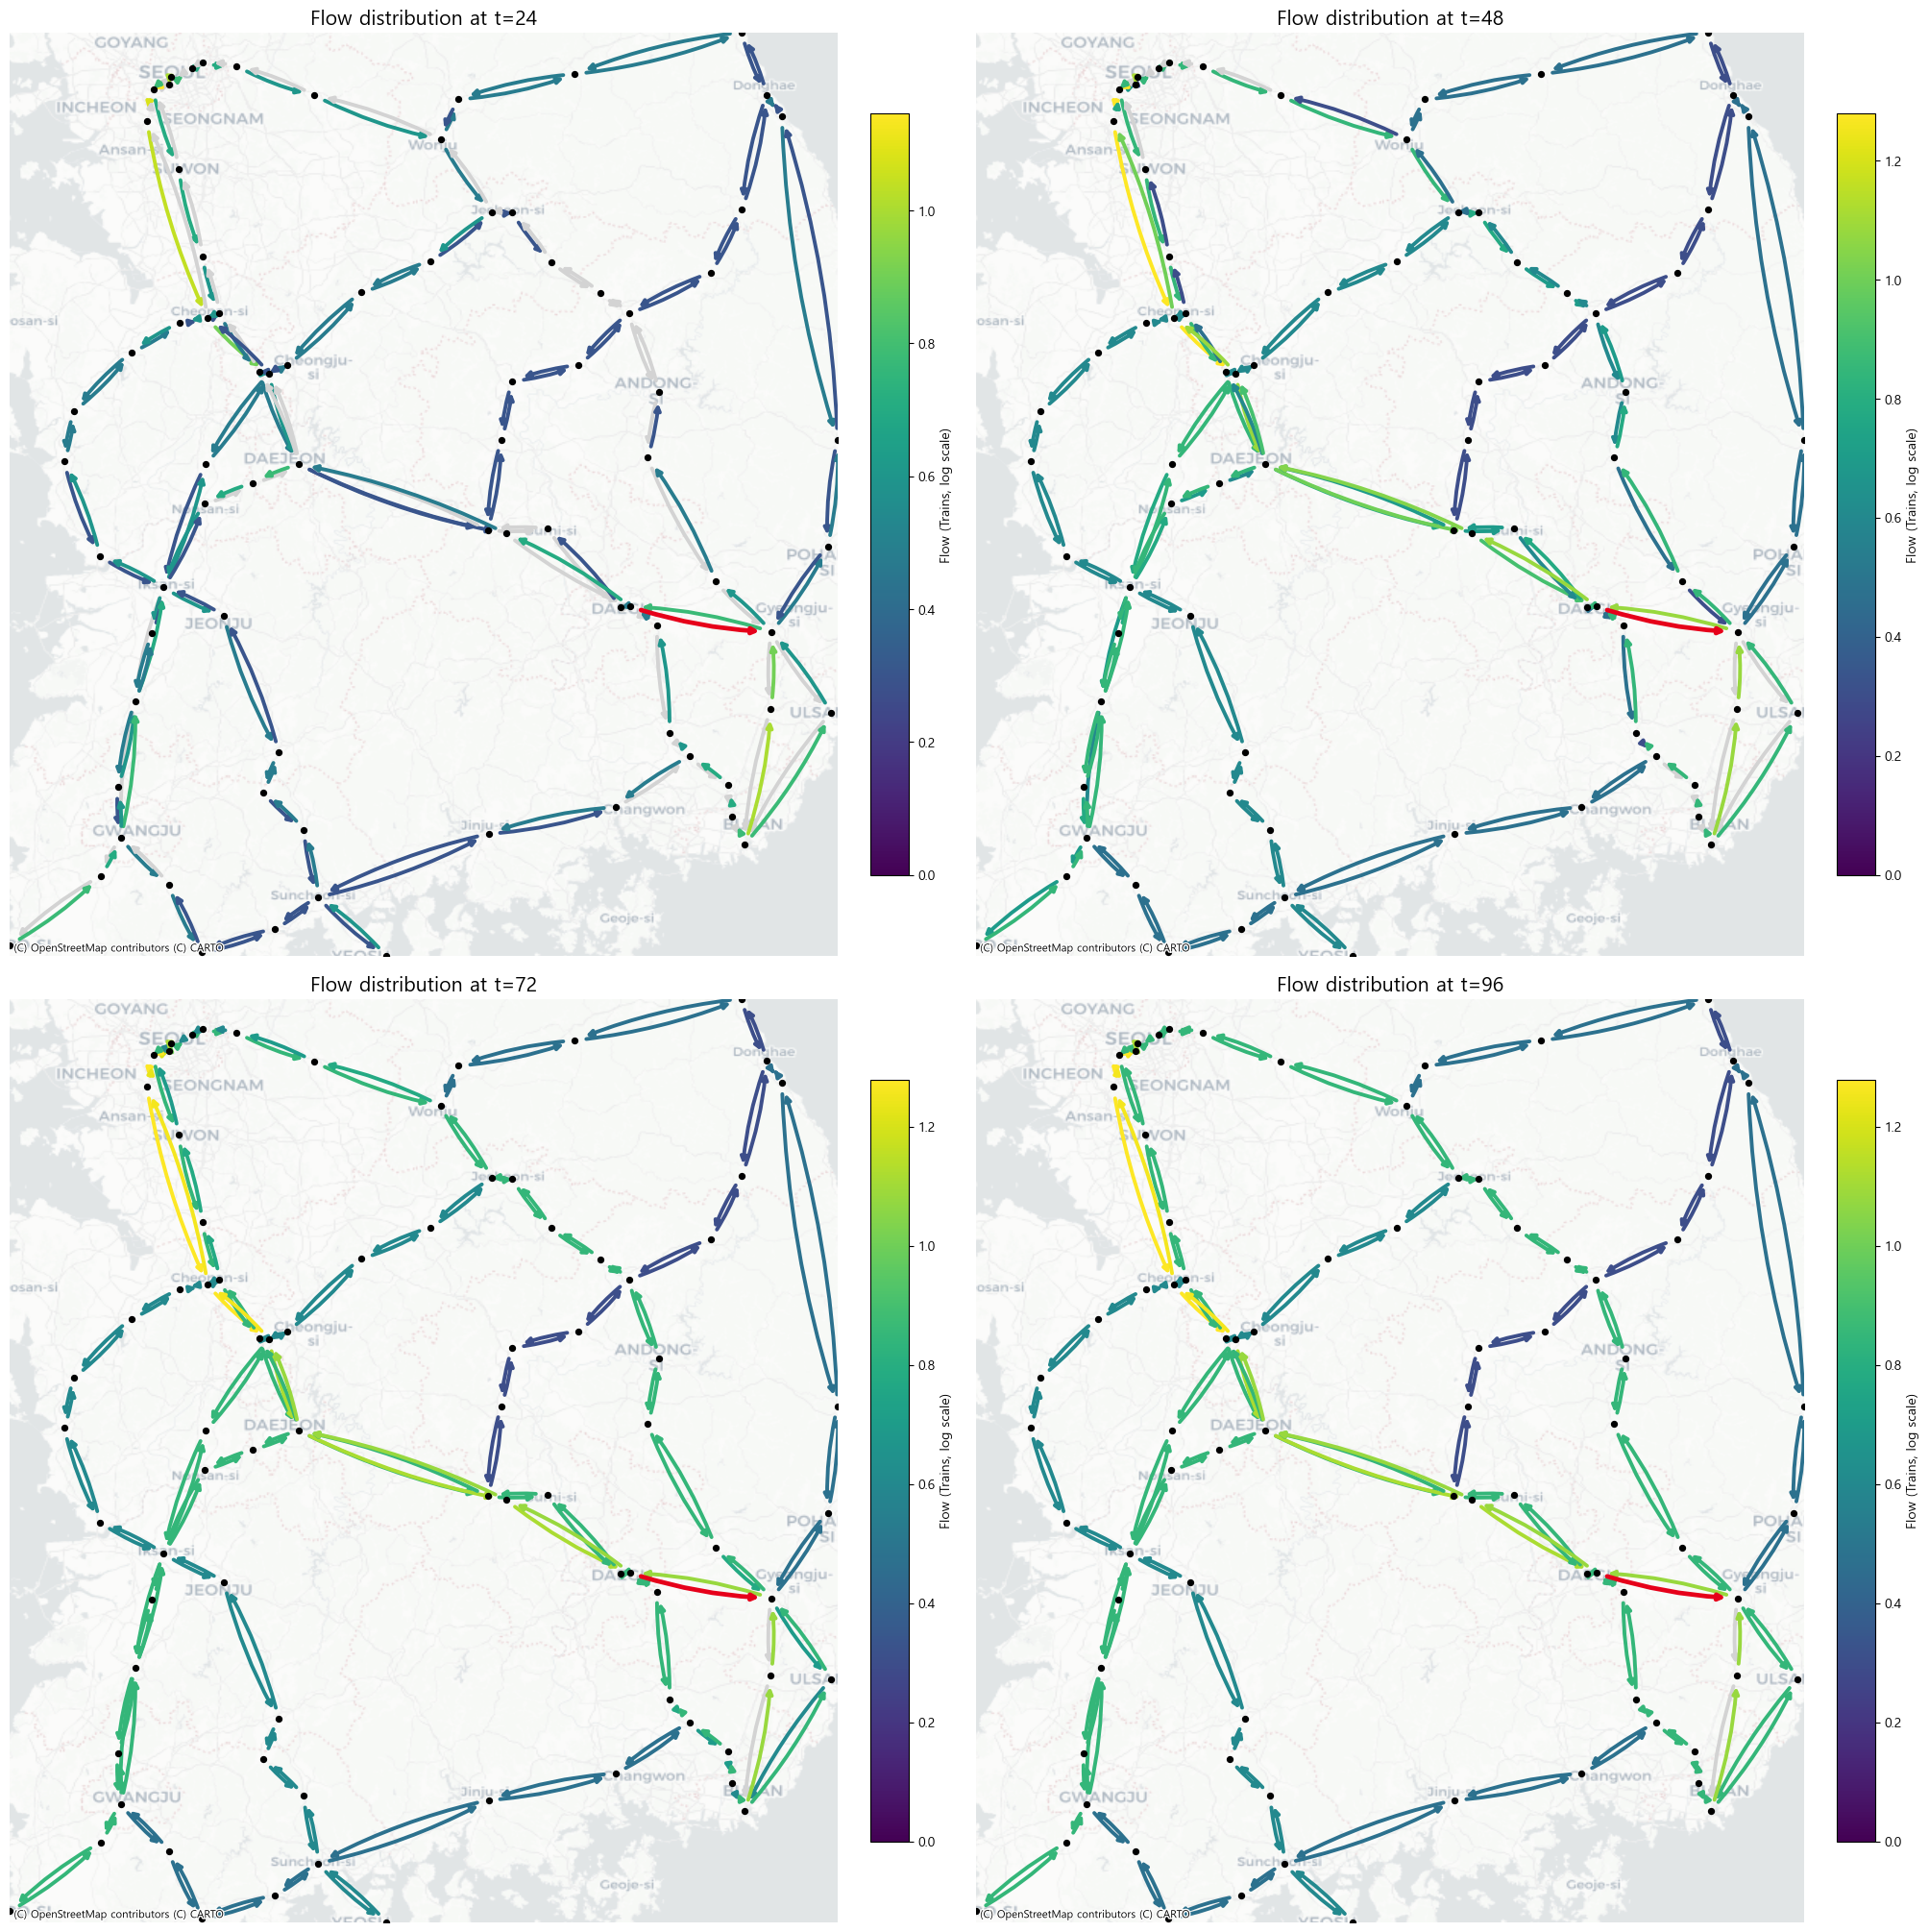

In [ ]:
# ============================================================
# timestep_flow_plot.py
# ----------------------
# (1) Gurobi 결과에서 시점별 edge-flow 계산
# (2) QGIS에서 export한 엑셀·JSON으로 좌표·수요 읽기
# (3) contextily + networkx 로 지도 시각화
#     - 엣지가 edge_fp에 존재하면 흐름이 0이어도 "무조건" 그린다
#     - demand에 없거나 흐름이 없는 것은 0으로 처리한다
#     - 컬러 스케일은 0부터 시작
# ============================================================

import json, math, itertools, contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely import wkt

# Matplotlib 한글 폰트 설정
try:
    import matplotlib.font_manager as fm
    font_name = fm.FontProperties(fname=fm.findfont('Malgun Gothic')).get_name()
    plt.rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
except:
    print("Warning: Malgun Gothic 폰트를 찾을 수 없습니다. 기본 폰트로 대체합니다.")

# ============================================================
# 0. 사용자 설정
# ============================================================
BASE      = Path(r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json")
xlsx_fp   = BASE / "qgis_export.xlsx"              # QGIS export 엑셀
edge_fp   = BASE / "edges.json"                    # 네트워크 엣지
flow_type = "trains"    # "trains" (열차 수) / "pax" (승객수 합)
# t_focus    = 12        # 단일 시점 대신 아래 리스트 사용
t_steps   = [24, 48, 72, 96]  # 한 번에 그릴 시점들
cumulative = True       # True: t<=t_focus 누적 / False: t 구간 내만

# ============================================================
# 1. Gurobi 결과 로딩 (변수가 메모리에 있다고 가정)
# ============================================================
# 이 스크립트를 실행하기 전에 x_val, arc_list, trains, demand, failed_edges 변수가
# 메모리에 로드되어 있어야 합니다.
# (이 부분은 사용자 환경에 맞게 직접 실행해야 함)

# ============================================================
# 2. split_node_time 유틸
# ============================================================
def split_node_time(s):
    """
    "n123^7"  → ("n123", 7)
    "n123"    → ("n123", None)
    123       → ("n123", None)
    "SINK"    → ("SINK", None)
    """
    if isinstance(s, (int, np.integer)):
        return f"n{int(s)}", None
    s = str(s)
    if "^" in s:
        node, t = s.split("^", 1)
        return node, int(t)
    if s.isdigit():
        return f"n{int(s)}", None
    return s, None

# ============================================================
# 3. QGIS Export: 노드·엣지 좌표 로딩
#    - 이 부분은 반복문 밖에 있어야 함
# ============================================================
with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

failed_pairs = {(s, d) for eid, (s, d, _) in edges.items() if eid in failed_edges}

node_df = pd.read_excel(xlsx_fp, sheet_name="NODE", usecols=["node_id", "geometry"])
edge_df = pd.read_excel(xlsx_fp, sheet_name="EDGE",
                        usecols=["edge_id", "from_node_id", "to_node_id", "geometry"])

node_gdf = gpd.GeoDataFrame(
    node_df.assign(geometry=node_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

edge_gdf = gpd.GeoDataFrame(
    edge_df.assign(geometry=edge_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

pos = {f"n{int(r.node_id)}": (r.geometry.x, r.geometry.y)
       for r in node_gdf.itertuples(index=False)}

edges_bidir = {}
for r in edge_gdf.itertuples(index=False):
    u = f"n{int(r.from_node_id)}"
    v = f"n{int(r.to_node_id)}"
    edges_bidir[(u, v)] = r.geometry
for (u, v), geom in list(edges_bidir.items()):
    if (v, u) not in edges_bidir:
        edges_bidir[(v, u)] = geom

# ============================================================
# 4. 시각화 (반복문)
#    - 모든 플롯을 하나의 Figure에 그림
# ============================================================
fig, axs = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True)
axs = axs.flatten() # 2x2 배열을 1차원 배열로 변경하여 반복문에서 쉽게 접근

for i, t_focus in enumerate(t_steps):
    ax = axs[i]
    
    # Gurobi 결과로부터 시점별 flow 집계
    edge_flow_t = defaultdict(float)
    for (idx, ti), val in x_val.items():
        if val < 0.5:
            continue
        fr_str, to_str, eid = arc_list[idx][:3]
        if eid.startswith(("w_", "dummy")):
            continue

        u_raw, t_dep = split_node_time(fr_str)
        v_raw, t_arr = split_node_time(to_str)
        if t_dep is None or t_arr is None:
            continue

        cond = (t_dep <= t_focus) if cumulative else (t_dep <= t_focus < t_arr)
        if not cond:
            continue

        if flow_type == "trains":
            edge_flow_t[(u_raw, v_raw)] += 1.0
        else:
            tr_name = trains[ti]
            q_tot   = sum(q for _, _, q in demand[tr_name]) if demand.get(tr_name) else 0.0
            edge_flow_t[(u_raw, v_raw)] += float(q_tot)

    # edge_flow_t에 없는 엣지도 0으로 채워 넣기(누락 방지)
    for (u, v) in edges_bidir.keys():
        if (u, v) not in edge_flow_t:
            edge_flow_t[(u, v)] = 0.0

    # NetworkX 그래프 생성
    G = nx.DiGraph()
    for n, xy in pos.items():
        G.add_node(n, pos=xy)
    for (u, v), geom in edges_bidir.items():
        flow = float(edge_flow_t.get((u, v), 0.0))
        G.add_edge(u, v, weight=flow, geom=geom)

    # 색상 매핑
    flows = [d["weight"] for _, _, d in G.edges(data=True)]
    logf  = [math.log10(max(0.0, f) + 1.0) for f in flows]
    vmax  = max(logf) if logf else 1.0
    if vmax <= 0: vmax = 1.0
    norm  = mpl.colors.Normalize(vmin=0.0, vmax=vmax)
    cmap  = sns.color_palette("viridis", as_cmap=True)

    # 시각화
    ax.set_facecolor("white")
    if pos:
        xs, ys = zip(*pos.values())
        ax.set_xlim(min(xs), max(xs))
        ax.set_ylim(min(ys), max(ys))
    ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron, alpha=0.7)

    # 엣지 그리기
    for (u, v, data) in G.edges(data=True):
        if (u, v) in failed_pairs:
            continue
        f = float(data["weight"])
        if f <= 0.0:
            color = "lightgray"   # 흐름이 0이면 회색
        else:
            lf = math.log10(f + 1.0)
            color = cmap(norm(lf))
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=2.8, edge_color=[color],
            arrowstyle="-|>", arrowsize=9, connectionstyle="arc3,rad=0.07", ax=ax
        )


    # 노드
    nx.draw_networkx_nodes(G, pos, node_size=18, node_color="black", ax=ax)

    # 실패 엣지
    for (u, v, data) in G.edges(data=True):
        if (u, v) not in failed_pairs: continue
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=3.4, edge_color=[(0.9, 0.0, 0.1, 1.0)],
            arrowstyle="-|>", arrowsize=9, connectionstyle="arc3,rad=0.07", ax=ax
        )

    # 컬러바 (흐름이 0보다 큰 경우만 반영)
    flows_nonzero = [f for f in flows if f > 0]
    if flows_nonzero:
        logf  = [math.log10(f + 1.0) for f in flows_nonzero]
        vmax  = max(logf)
        norm  = mpl.colors.Normalize(vmin=0.0, vmax=vmax)
        sm    = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
        cbar  = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        label = "Trains" if flow_type == "trains" else "Passengers"
        cbar.set_label(f"Flow ({label}, log scale)")

    ax.set_title(f"Flow distribution at t={t_focus}", fontsize=15)
    ax.axis("off")

plt.show()